In [747]:
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning: Programming Exercise 3
## Multi-class Classification and Neural Networks
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classification task. In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.
### 1.1 Dataset
You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits*. The `.mat` format means that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a `.csv` file. These matrices can be read directly into your program by using the `scipy.io.loadmat` function. After loading, matrices of the correct dimensions and values will appear in your program's memory.

*This is a subset of the [MNIST database](http://yann.lecun.com/exdb/mnist/).
Run the code below to load the dataset.

In [748]:
# Load saved matrices from file
import scipy.io

data = scipy.io.loadmat('ex3data1.mat')
X = data['X']
y = data['y']
print(X.shape, y.shape)

(5000, 400) (5000, 1)


There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$X = \begin{bmatrix} - (x^{(1)})^T - \\ - (x^{(2)})^T - \\ - \vdots - \\ - (x^{(m)})^T - \end{bmatrix}$$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

### 1.2 Visualizing the data
You will begin by visualizing a subset of the training set. In the following cell, the code randomly selects 100 rows from `X` and passes those rows to the `display_data` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the `display_data` function, and you are encouraged to examine the code to see how it works.

In [749]:
def display_data(x, example_width=None):
    if not example_width:
        example_width = int(np.round(np.sqrt(x.shape[1])))

    m, n = x.shape
    example_height = int(n / example_width)

    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    pad = 1

    display_array = -np.ones((pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)))

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break

            max_val = np.max(np.abs(x[curr_ex, :]))
            display_array[pad + j * (example_height + pad) + np.arange(example_height), pad + i * (
                    example_width + pad) + np.arange(example_width)[:, np.newaxis]] = x[curr_ex, :].reshape(
                (example_height, example_width), order='F') / max_val
            curr_ex += 1

        if curr_ex >= m:
            break

    plt.imshow(display_array, cmap='gray')
    plt.axis('off')
    plt.show()

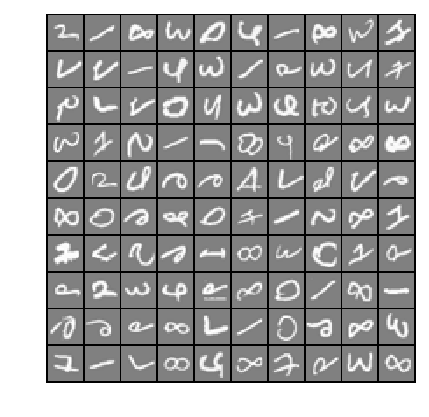

In [750]:
m = X.shape[0]
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
display_data(sel)

### 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise.
#### 1.3.1 Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is defined as:
$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]$$
To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as:
$$X = \begin{bmatrix} - (x^{(1)})^T - \\ - (x^{(2)})^T - \\ - \vdots - \\ - (x^{(m)})^T - \end{bmatrix} \quad \text{and} \quad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}$$
In the last equation, $\theta$ is a vector of shape $(n + 1, 1)$, and $X$ is a matrix of shape $(m, n + 1)$. By computing the matrix product $X\theta$, we can compute the values of $h_\theta(x^{(i)})$ for all our examples $i$ in one line of code.
Your job is to write the unregularized cost function `lr_cost_function` that computes the cost of using $\theta$ as the parameter for logistic regression to fit the data in `X` and `y`. If you are using your code from the previous exercise, make sure you modify it to set the `lambda_` parameter to 0. You can implement this function by completing the code in the following cell.

In [751]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as:
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)}$$
To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$:
$$\left[ \begin{array}{c} \frac{\partial J(\theta)}{\partial \theta_0} \\ \frac{\partial J(\theta)}{\partial \theta_1} \\ \frac{\partial J(\theta)}{\partial \theta_2} \\ \vdots \\ \frac{\partial J(\theta)}{\partial \theta_n} \end{array} \right] = \frac{1}{m} \left[ \begin{array}{c} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} \\ \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_1^{(i)} \\ \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_2^{(i)} \\ \vdots \\ \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_n^{(i)} \end{array} \right] = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x^{(i)} = \frac{1}{m} X^T (h_\theta(x) - y) \;\;\; (1)$$
where 
$$h_\theta(x) - y = \begin{bmatrix} h_\theta(x^{(1)}) - y^{(1)} \\ h_\theta(x^{(2)}) - y^{(2)} \\ \vdots \\ h_\theta(x^{(m)}) - y^{(m)} \end{bmatrix}$$
Note that $x^{(i)}$ is a vector, while $(h_\theta(x^{(i)}) - y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta = h_\theta(x) - y$ and observe that:
$$\sum_i \beta_i x^{\left(i\right)} =\left\lbrack \begin{array}{cccc}
| & | & \; & |\\
x^{\left(1\right)}  & x^{\left(2\right)}  & \ldots & x^{\left(m\right)} \\
| & | & \; & |
\end{array}\right\rbrack \left\lbrack \begin{array}{c}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m 
\end{array}\right\rbrack =X^T \beta ,$$
The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement equation (1) to compute the correct vectorized gradient. Once you are done, complete the function `lr_cost_function` by implementing the gradient.

In [752]:
def lr_cost_function(theta, x, y, lambda_):
    m = y.size
    z = x.dot(theta)
    h = sigmoid(z)
    J = (1 / m) * (-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)

    theta_j = np.copy(theta)
    theta_j[0] = 0
    grad = (x.T.dot(h - y)) / m + (lambda_ / m) * theta_j
    return J, grad

#### 1.3.3 Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as:
$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2$$
Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as:
$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} \quad \text{for} \quad j = 0$$
$$\frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \quad \text{for} \quad j \geq 1$$
Now modify your code in `lr_cost_function` to account for regularization. Once again you should not put any loops into your code. When you are finished, run the following code below to test your vectorized implementation and compare to expected outputs:

In [753]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.column_stack((np.ones(5), np.arange(1, 16).reshape(3, 5).T / 10))
y_t = np.array([1, 0, 1, 0, 1])
lambda_t = 3
J, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)
print('Cost: {:.6f} | Expected cost: 2.534819'.format(J))

Cost: 2.534819 | Expected cost: 2.534819


In [754]:
print('Gradients:');
print(grad)

Gradients:
[ 0.14656137 -0.54855841  0.72472227  1.39800296]


In [755]:
print('Expected gradients:\n [0.146561\t -0.548558\t 0.724722\t 1.398003]')

Expected gradients:
 [0.146561	 -0.548558	 0.724722	 1.398003]


### 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 
You should now complete the code in `one_vs_all` to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K \times (N + 1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a "for"-loop from 1 to $K$, training each classifier independently.
Note that the `y` argument to this function is a vector of labels from 1 to 10, where we have mapped the digit "0" to the label 10 (to avoid confusions with indexing). When training the classifier for class $k \in \{1, \dots, K\}$, you will want a $m$-dimensional vector of labels $y$, where $y_j \in \{0, 1 \}$ indicates whether the $j$-th training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different class $(y_j = 0)$. You may find logical arrays helpful for this task.

In [756]:
a = np.arange(1, 11)
b = 3
print([int(i) for i in (a == b)])

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Furthermore, you will be using `scipy`'s optimization module for this exercise. After you have correctly completed the code for `one_vs_all`, run the following cell to train a multi-class classifier.

In [757]:
from scipy.optimize import minimize


def one_vs_all(x, y, num_labels, lambda_):
    m, n = x.shape
    all_theta = np.zeros((num_labels, n + 1))
    x = np.column_stack((np.ones(m), x))
    y = np.squeeze(y)
    initial_theta = np.zeros(n + 1)
    for i in range(num_labels):
        res = minimize(lr_cost_function, initial_theta, args=(x, (y == i).astype(int), lambda_), method='BFGS',
                       jac=True, options={'maxiter': 50})
        all_theta[i] = res.x
    return all_theta

In [758]:
num_labels = 10
lambda_ = 0.1
all_theta = one_vs_all(X, y, num_labels, lambda_)

### 1.4.1 One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the "probability" that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label $(1, 2, \dots, K)$ as the prediction for the input example. 
You should now complete the code in `predict_one_vs_all` to use the one-vs-all classifier for making predictions.
Once you are done, run the code below to call your `predict_one_vs_all` function using the learned value of $\Theta$. You should see that the training set accuracy is about 94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).

In [759]:
def predict_one_vs_all(all_theta, x):
    m = x.shape[0]
    x = np.column_stack((np.ones(m), x))
    p = np.argmax(sigmoid(x.dot(all_theta.T)), axis=1)
    return p

In [760]:
pred = predict_one_vs_all(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y.ravel()) * 100))

Training Set Accuracy: 83.42%


In [761]:
# Randomly permute examples
rp = np.random.randint(m)
# Predict
pred = predict_one_vs_all(all_theta, X[rp, np.newaxis])
print('One-vs-all Prediction: {} (digit {})'.format(pred[0], pred[0] % 10))

One-vs-all Prediction: 3 (digit 3)


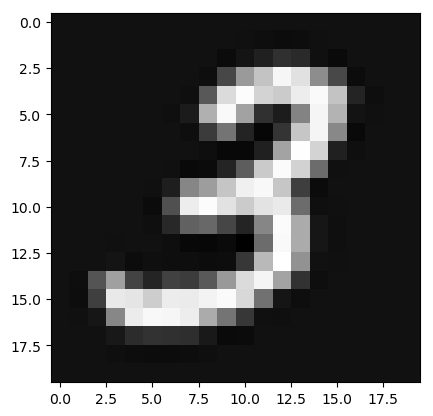

In [762]:
# Display
plt.imshow(X[rp].reshape((20, 20)).T, cmap='gray')